<a href="https://colab.research.google.com/github/kuolunwang/Image-Processing/blob/main/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# library
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from google.colab.patches import cv2_imshow
%matplotlib inline

In [ ]:
# load picture from google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# loaded the image in grayscale
image = cv2.imread('/content/drive/MyDrive/Car On Mountain Road.tif',0)

In [ ]:
# LoG 
laplacian_kernel = np.zeros((3,3))
laplacian_kernel[0] = [-1,-1,-1]
laplacian_kernel[1] = [-1,8,-1]
laplacian_kernel[2] = [-1,-1,-1]

def LoG(image):

  size = 25
  sigma = 4

  x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                        np.arange(-size/2+1, size/2+1))
  normal = 1 / (2.0 * np.pi * sigma**2)
  kernel = np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal

  img_smooth = cv2.filter2D(image,-1,kernel)

  LoG_image = cv2.filter2D(img_smooth,-1,laplacian_kernel)

  return LoG_image

In [ ]:
# normalize LoG
log = LoG(np.float32(image))
LoG = (log-np.min(log))/(np.max(log)-np.min(log))

In [ ]:
# show result of LoG
cv2_imshow(LoG*255)

In [ ]:
# zero crossing
def zero_cross(image,thres):
  h,w = image.shape
  output = np.zeros(image.shape)
  for y in range(1, h - 1):
      for x in range(1, w - 1):
          patch = image[y-1:y+2, x-1:x+2]
          p = image[y, x]
          maxP = patch.max()
          minP = patch.min()
          if (p > 0):
              zeroCross = True if minP < 0 else False
          else:
              zeroCross = True if maxP > 0 else False
          if ((maxP - minP) > thres) and zeroCross:
              output[y, x] = 1
  return output

In [ ]:
# 0% and 4% thres
zero_percent = zero_cross(log,0)
four_thres = 0.04 * (np.max(log)-np.min(log))
four_percent = zero_cross(log,four_thres)

In [ ]:
# show 0% image
cv2_imshow(zero_percent*255)

In [ ]:
# show 4% image
cv2_imshow(four_percent*255)

In [ ]:
# hough trangform
def hough_line(img):

    thetas = np.deg2rad(np.arange(-90.0, 90.0, 1))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)



    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    y_idxs, x_idxs = np.nonzero(img)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))

            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


In [ ]:
# hough transform
ac, th , rh = hough_line(four_percent)

In [ ]:
# show picture of hough transform
def show_hough_line(img, accumulator, thetas, rhos):

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='gray',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1500], rhos[1500]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')
    plt.show()

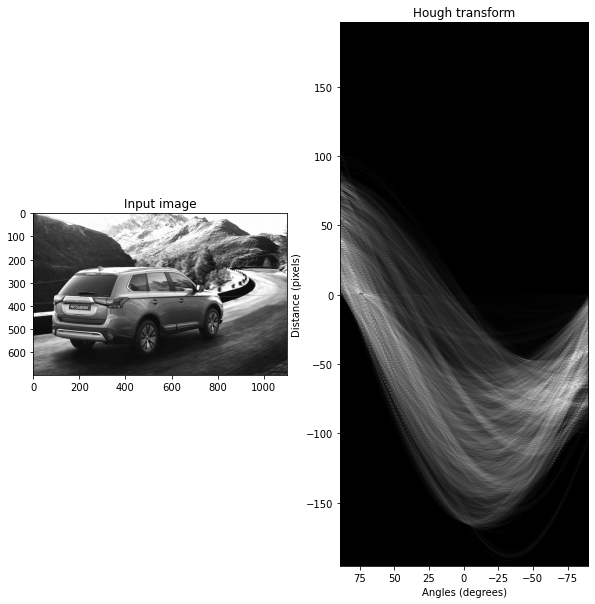

In [ ]:
# show image
show_hough_line(image, ac, th, rh)

In [ ]:
# draw line
def write_lines(image, hough_space):

		y_length, x_length = image.shape
		thetas = np.deg2rad(np.arange(-90.0, 90.0, 1))
		max_distance = int(math.ceil(math.sqrt(y_length*y_length + x_length*x_length)))
		for i_pho in range(hough_space.shape[0]):
			for i_theta in range(hough_space.shape[1]):
				if hough_space[i_pho][i_theta] == 255 :
					theta = thetas[i_theta]
					pho = i_pho - max_distance
					a = math.cos(theta)
					b = math.sin(theta)
					x0 = a*pho
					y0 = b*pho
					x1 = int(x0 + 10000*(-b))
					y1 = int(y0 + 10000*(a))
					x2 = int(x0 - 10000*(-b))
					y2 = int(y0 - 10000*(a))
					cv2.line(image,(x1,y1),(x2,y2),120)
		return image

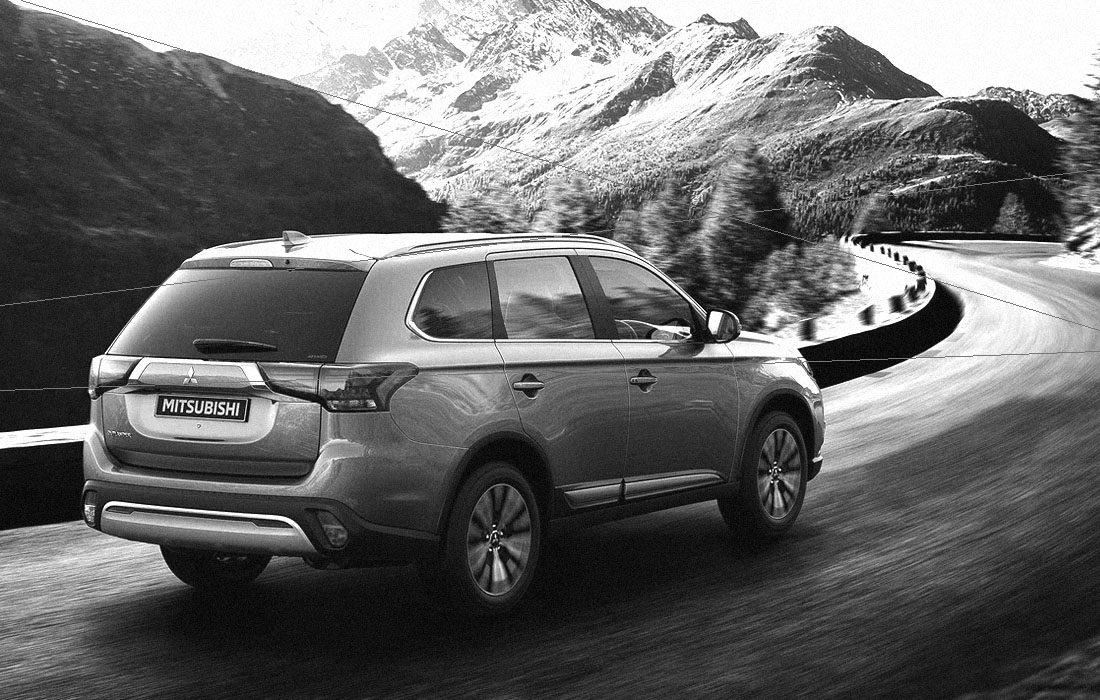

In [ ]:
# draw in image
im = write_lines(image, ac)
cv2_imshow(im)

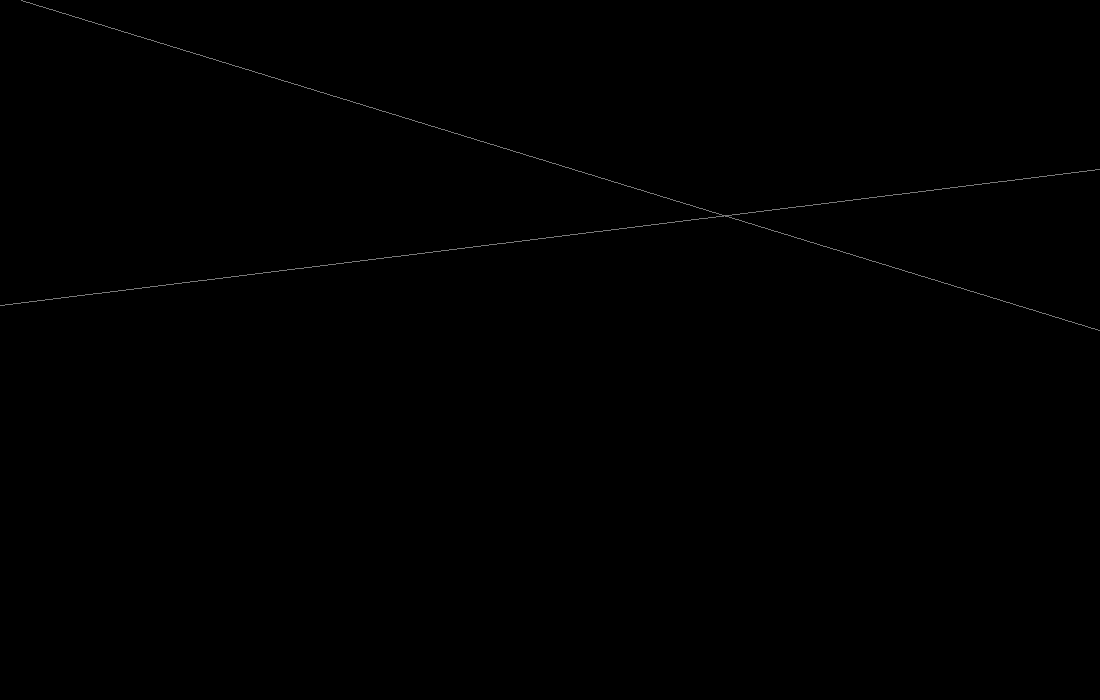

In [ ]:
# draw line
raw = np.zeros(image.shape)
im = write_lines(raw, ac)
cv2_imshow(im)